In [ ]:
import pandas as pd
import sklearn

df = pd.read_csv('/nba_train.csv')

In [ ]:
keys_info_fp = '/player_stats.csv'
info_df = pd.read_csv(keys_info_fp)

In [ ]:
target_column = 'TARGET_5Yrs'
outlier_threshold = -1 # z-score (-1 for none)
random_state = 1000

X = df.drop(columns=[target_column,])
y = df[target_column]

#### Evaluation util functions
- Accuracy scores
- Confusion matrix/report
- ROC Curve/AUC score

In [ ]:
from sklearn.metrics import accuracy_score

def evaluate_classifier(clf, X_train, y_train, X_test, y_test, name):
    """
    Evaluate the classifier and print the accuracy, test score, and train score.
    """
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)

    return (name, accuracy, train_score, test_score)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

def plot_confusion_matrix(y_true, y_pred):
    # print(
    #     f"\ntrue negatives (class 0 correctly predicted)"
    #     f"\nfalse positives (class 1 incorrectly predicted as class 0)"
    #     f"\nfalse negatives (class 0 incorrectly predicted as class 1)"
    #     f"\ntrue positives (class 1 correctly predicted)"
    # )
    mat = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(mat)
    fig, ax = plt.subplots()
    disp.plot(ax=ax)
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    return image


from sklearn.metrics import classification_report

def get_confusion_m_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    return report_df

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc_curve(y_test, y_probs):
    # AUC for the positive class (1)
    auc1 = roc_auc_score(y_test, y_probs[:, 1])

    # Plot the ROC curve for the positive class (1)
    fig, ax = plt.subplots()
    fpr, tpr, _ = roc_curve(y_test, y_probs[:, 1])
    ax.plot(fpr, tpr, color='blue', lw=2, label='Class 1 ROC curve (area = {:.3f})'.format(auc1))

    # Plot the random chance line
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic')
    ax.legend(loc="lower right")
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    return image, auc1

In [ ]:
def plot_images_grid(images, num_cols=3, title=''):
    num_rows = (len(images) // num_cols) + 1
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    fig.suptitle(title, fontsize=16)
    fig.tight_layout(pad=3.0)
    for i, (name, image) in enumerate(images):
        row = i // num_cols
        col = i % num_cols
        axs[row, col].imshow(image)
        axs[row, col].set_title(name)
        axs[row, col].axis('off')
    # Hide empty subplots
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axs.flatten()[j])
    plt.show()
    return fig

In [ ]:
import shutil
from google.colab import files

def download_folder_as_zip(folder_path, zip_name):
    """
    Zips the specified folder and downloads it as a zip file.

    Args:
        folder_path: Path to the folder to be zipped and downloaded.
        zip_name: The name of the resulting zip file (without .zip extension).
    """
    shutil.make_archive(zip_name, 'zip', folder_path)
    files.download(f'{zip_name}.zip')

In [ ]:
import os

def delete_all_files_in_folder(folder_path):
    """
    Deletes all files inside the specified folder.

    Args:
        folder_path: Path to the folder where files will be deleted.
    """
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')

### Outliers removal

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import zscore

# remove outliers with z-score threshold
def remove_outliers(data, threshold=outlier_threshold):
    z_scores = np.abs(zscore(data))
    filtered_entries = (z_scores < threshold).all(axis=1)
    return data[filtered_entries]

if outlier_threshold != -1:
  target_column = 'TARGET_5Yrs'
  columns_to_check = df.columns[~df.columns.isin(['Id', target_column])]

  # Apply outlier removal on the entire DataFrame except for 'Id' and target_column
  df_cleaned = df.copy()
  df_cleaned[columns_to_check] = remove_outliers(df[columns_to_check])

  # Drop any rows that contain NaN values resulting from the outlier removal
  df_cleaned.dropna(inplace=True)

  df = df_cleaned

## 1. NN

[See docs](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

[NNs](https://scikit-learn.org/stable/modules/neural_networks_supervised.html#)

In [ ]:
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.model_selection import train_test_split

# Applying SelectPercentile for Neural Network
select_percentile = SelectPercentile(f_classif, percentile=50)
X_select_percentile = select_percentile.fit_transform(X, y)

selected_features = X.columns[select_percentile.get_support()]
X_select_percentile_df = pd.DataFrame(X_select_percentile, columns=selected_features)

print("Selected features for Neural Network using SelectPercentile:")
print(selected_features)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_select_percentile_df, y, test_size=0.3, random_state=random_state)

Selected features for Neural Network using SelectPercentile:
Index(['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FTM', 'FTA', 'OREB', 'DREB', 'REB'], dtype='object')


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.neural_network import MLPClassifier

hidden_layer_sizes = (10, 5,)
random_state = 1000
params = {
    "hidden_layer_sizes": hidden_layer_sizes,
    "early_stopping": True,
    "verbose": False,
    "random_state": random_state,
    "validation_fraction": 0.2,
}
clf = MLPClassifier(**params)
clf.fit(X_train, y_train)

params = {
    'hidden_layer_sizes': hidden_layer_sizes,
    'activation': 'identity',
    'solver': 'adam',
    'learning_rate': "adaptive",
    'learning_rate_init': 0.01,
    'random_state': 1000,
    'validation_fraction': 0.2,
    'alpha': 0.01, # max 0.02
}

MLPClassifier(activation='identity', alpha=0.01, hidden_layer_sizes=(10, 5),
              learning_rate='adaptive', learning_rate_init=0.01,
              random_state=1000, validation_fraction=0.2)

0.8360119047619048
AUC: 0.7121862097533227


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
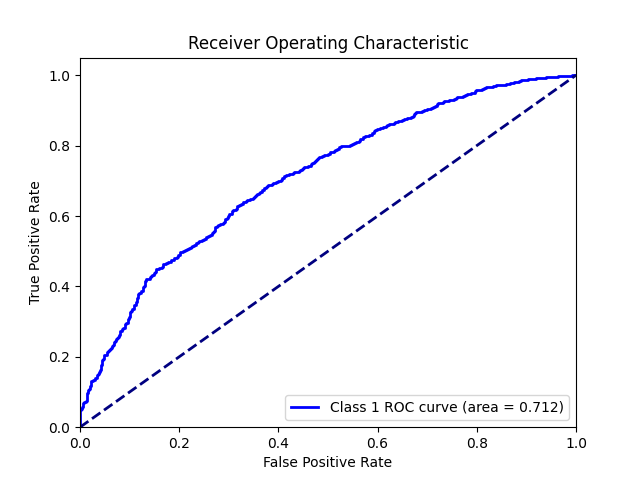

In [ ]:
name = 'NN'
eval = evaluate_classifier(clf, X_train, y_train, X_test, y_test, name)

# Confusion matrix and report
#y_pred = clf.predict(X_test)
#confusion_report = get_confusion_m_report(y_test, y_pred)
#confusion_reports[name] = confusion_report
#confusion_matrix_images.append((name, plot_confusion_matrix(y_test, y_pred)))

# ROC/AUC
y_probs = clf.predict_proba(X_test)
roc_image, auc = plot_roc_curve(y_test, y_probs)

print(eval[3])
print(f"AUC: {auc}")
roc_image

In [ ]:
import pandas as pd
from sklearn.neural_network import MLPClassifier

test_fp = '/content/nba_test.csv'
test_df = pd.read_csv(test_fp)
test_df = pd.DataFrame(test_df, columns=selected_features)
Xk_test = test_df

# Predict probabilities for the test set
probabilities = clf.predict_proba(Xk_test)[:, 1]  # probability for class 1

results_df = pd.DataFrame({
    'Id': range(len(probabilities)),
    'TARGET_5Yrs': probabilities
})

# Save the results
results_fp = 'kaggle_results.csv'
results_df.to_csv(results_fp, index=False)
results_df[0:100]


Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

fixed_params = {
    'activation': 'identity',
    'solver': 'adam',
    'learning_rate': 'adaptive',
    'learning_rate_init': 0.0008,
    'random_state': random_state,
    'validation_fraction': 0.2,
}

# grid for the other parameters
param_grid = {
    'hidden_layer_sizes': [hidden_layer_sizes],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'max_iter': [200, 300, 400,],
    'tol': [1e-5, 1e-4, 1e-3]
}

grid_search = GridSearchCV(
    estimator=MLPClassifier(**fixed_params, ),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,         # cross-validation
    n_jobs=-1,
)
grid_search.fit(X_train, y_train)

In [ ]:
# Print the accuracy
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
predictions = best_estimator.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

print("Best score:", grid_search.best_score_)
print("Accuracy on the test set:", accuracy)
print(f"Best Parameters: {best_params}")

## 2. DT
[See docs](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
[DT](https://scikit-learn.org/stable/modules/tree.html)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn.model_selection import train_test_split

# Applying RFE for Decision Tree
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=12)
X_rfe = rfe.fit_transform(X, y)
selected_features = X.columns[rfe.get_support()]
X_rfe_df = pd.DataFrame(X_rfe, columns=selected_features)

print("Selected features for Decision Tree using RFE:")
print(selected_features)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_rfe_df, y, test_size=0.3, random_state=random_state)

Selected features for Decision Tree using RFE:
Index(['Id', 'GP', 'MIN', 'FGA', 'FG%', '3PA', '3P%', 'FTM', 'FT%', 'REB',
       'AST', 'TOV'],
      dtype='object')


In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

params = {
  'max_depth': 3,
  'min_samples_leaf': 6,
}
clf = DecisionTreeClassifier(**params)
clf.fit(X_train, y_train)
clf.feature_importances_
plot_tree(clf)

params = {
  'max_depth': 6,
  'min_samples_leaf': 2,
  'min_samples_split': 20,
}

('DT', 0.8129166666666666, 0.8444642857142857, 0.8129166666666666)
AUC: 0.6622955068552948


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
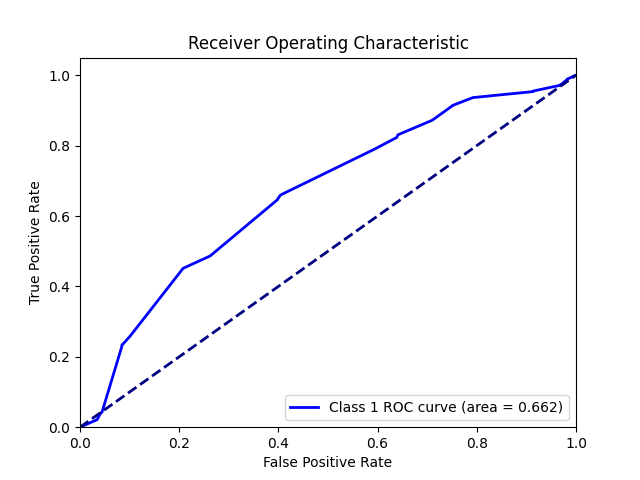

In [ ]:
name = 'DT'
eval = evaluate_classifier(clf, X_train, y_train, X_test, y_test, name)

# Confusion matrix and report
#y_pred = clf.predict(X_test)
#confusion_report = get_confusion_m_report(y_test, y_pred)
#confusion_reports[name] = confusion_report
#confusion_matrix_images.append((name, plot_confusion_matrix(y_test, y_pred)))

# ROC/AUC
y_probs = clf.predict_proba(X_test)
roc_image, auc = plot_roc_curve(y_test, y_probs)

print(eval)
print(f"AUC: {auc}")
roc_image

In [ ]:
import pandas as pd
from sklearn.neural_network import MLPClassifier

test_fp = '/content/nba_test.csv'
test_df = pd.read_csv(test_fp)
test_df = pd.DataFrame(test_df, columns=selected_features)
Xk_test = test_df

probabilities = clf.predict_proba(Xk_test)[:, 1]

results_df = pd.DataFrame({
    'Id': range(len(probabilities)),
    'TARGET_5Yrs': probabilities
})

In [ ]:
results_fp = 'kaggle_results.csv'
results_df.to_csv(results_fp, index=False)
results_df[0:100]

Grid search

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

param_grid = {
    'max_depth': [4, 6, 8, 10, 12],
    'min_samples_split': [5, 10, 15, 20, 25],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}
clf = DecisionTreeClassifier()
gs = GridSearchCV(estimator=clf, param_grid=param_grid, cv=4, verbose=1, n_jobs=-1)
gs.fit(X_train, y_train)

Fitting 4 folds for each of 125 candidates, totalling 500 fits
Best parameters: {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 20}
Best score: 0.8317857142857144
Accuracy on the test set: 0.82625


In [ ]:
# Get the best model and its performance
best_model = gs.best_estimator_
predictions = best_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

# Print the results
print("Best parameters:", gs.best_params_)
print("Best score:", gs.best_score_)
print("Accuracy on the test set:", accuracy)

## Refactored data normalisation

Bining


In [ ]:
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

columns_to_bin = ['REB']
num_bins = 10
binner = KBinsDiscretizer(n_bins=num_bins, encode='ordinal', strategy='quantile')

for column in columns_to_bin:
    if column in X.columns:
        bins = binner.fit_transform(X[[column]])
        X_select_percentile_df[column + '_binned'] = bins

# Apply one-hot encoding to the binned columns
binned_columns = [col + '_binned' for col in columns_to_bin if col in X.columns]
encoder = OneHotEncoder(sparse=False)
X_binned_encoded = encoder.fit_transform(X_select_percentile_df[binned_columns])

# Create a DataFrame with the one-hot encoded columns
encoded_df = pd.DataFrame(X_binned_encoded, columns=encoder.get_feature_names_out(binned_columns))

# Drop the original binned columns and concatenate the one-hot encoded columns
X_select_percentile_df.drop(columns=binned_columns, inplace=True)
X_select_percentile_df = pd.concat([X_select_percentile_df.reset_index(drop=True), encoded_df], axis=1)

# Split the data again after binning and encoding
X_train, X_test, y_train, y_test = train_test_split(X_select_percentile_df, y, test_size=0.3, random_state=random_state)



Min max scaling

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Columns to scale
columns_to_scale = ['REB', 'PTS', 'GP']

# Apply MinMaxScaler to specified columns
min_max = MinMaxScaler()
X_select_percentile_df[columns_to_scale] = min_max.fit_transform(X_select_percentile_df[columns_to_scale])

# Summarize the scaled data
print(X_select_percentile_df.describe())

Feature selection

In [ ]:
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, SelectKBest, SelectPercentile, f_classif, RFE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector

if explore_best_feat_selection:
  target_column = 'TARGET_5Yrs'
  X = df.drop(columns=[target_column])
  y = df[target_column]

  # Define feature selection methods
  feature_selections = {
      # For DT and RF
      'RFE': RFE(estimator=DecisionTreeClassifier()),
      'TreeBased': SelectFromModel(ExtraTreesClassifier(n_estimators=50)),
      'VarianceThreshold': VarianceThreshold(threshold=(.8 * (1 - .8))),

      # For NNs
      'SelectKBest': SelectKBest(f_classif, k=5),
      'SelectPercentile': SelectPercentile(f_classif, percentile=50),
      'SFS': SequentialFeatureSelector(estimator=DecisionTreeClassifier(), n_features_to_select=5, direction='forward')
  }

  # Function to evaluate feature selection methods
  def evaluate_feature_selection(X, y, feature_selections, classifier):
      results = {}
      for name, selector in feature_selections.items():
          pipe = Pipeline([
              ('feature_selection', selector),
              ('classifier', classifier)
          ])
          scores = cross_val_score(pipe, X, y, cv=5)
          results[name] = scores.mean()
      return results

  # Function to print and plot results
  def print_and_plot_results(X, y, classifier, classifier_name):
      results = evaluate_feature_selection(X, y, feature_selections, classifier)

      print(f"Feature Selection Performance for {classifier_name}:")
      for method, score in results.items():
          print(f"{method}: {score:.4f}")

      best_method = max(results, key=results.get)
      print(f"\nBest Feature Selection Method for {classifier_name}: {best_method}")

      best_selector = feature_selections[best_method]
      X_new = best_selector.fit_transform(X, y)

      # Get the boolean mask of selected features
      selected_features = best_selector.get_support()

      # Get the names of the selected features
      selected_feature_names = X.columns[selected_features]

      # Print the names of the selected features
      print("Selected Features:")
      for feature in selected_feature_names:
          print(feature)

      X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=1000)

      classifier.fit(X_train, y_train)

      if isinstance(classifier, DecisionTreeClassifier):
          plt.figure(figsize=(20,10))
          plot_tree(classifier, filled=True, feature_names=X.columns[best_selector.get_support()], class_names=['0', '1'])
          plt.show()

      y_train_pred_proba = classifier.predict_proba(X_train)[:, 1]
      y_test_pred_proba = classifier.predict_proba(X_test)[:, 1]

      train_auc = roc_auc_score(y_train, y_train_pred_proba)
      test_auc = roc_auc_score(y_test, y_test_pred_proba)
      print(f"Training AUC for {classifier_name}: {train_auc:.4f}")
      print(f"Testing AUC for {classifier_name}: {test_auc:.4f}")

      fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
      plt.figure()
      plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = %0.2f)' % test_auc)
      plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title(f'Receiver Operating Characteristic for {classifier_name}')
      plt.legend(loc="lower right")
      plt.show()

  # Evaluate and print results for Decision Tree
  print_and_plot_results(X, y, DecisionTreeClassifier(max_depth=3, max_leaf_nodes=5), "Decision Tree")

  # Evaluate and print results for Random Forest
  #print_and_plot_results(X, y, RandomForestClassifier(n_estimators=100), "Random Forest")

  # Evaluate and print results for Neural Network
  print_and_plot_results(X, y, MLPClassifier(max_iter=1000), "Neural Network")

# DT
# RFE: 0.8336 (0.6849)
# TreeBased: 0.8334 (0.6839)
# VarianceThreshold: 0.8334 (0.6839)

# RFE Selected Features:
# GP
# MIN
# FGA
# FG%
# 3PA
# 3P%
# FT%
# REB
# AST

# NN
#SelectPercentile: 0.8334 (AUC 0.7031)
#SelectKBest: 0.8332 (AUC 0.6954)
#SFS: 0.8334 (AUC 0.6930)

# SelectedPercentile features
# GP
# MIN
# PTS
# FGM
# FTM
# FTA
# OREB
# DREB
# REB